## Testing Category Discovery Using KCM

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.svm import SVC
from kcm.koopman_category_model import KoopmanCategoryModel
from kcm.discovery import sup_con_loss, BaselineModel, HASHHead, cluster_acc, split_cluster_acc_v1, split_cluster_acc_v2, create_hash_ids
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
num_cats = 4
num_samples = 100
system_dimension = 1
delay_embeddings = 5 # 3
num_segments = 5
svd_rank = None
dmd_rank = None
q = 1
num_clusters = 5
test_size = 0.2
codebook_training_size = 45 # divides <num training classes> * num_segments 
category_discovery=True
train_classes = range(3)
noisy_data=False
noise_std=0.01
normalize_inputs=True
seed = 42

KCM = KoopmanCategoryModel(num_cats=num_cats,
                           num_samples=num_samples,
                           system_dimension=system_dimension,
                           delay_embeddings=delay_embeddings,
                           num_segments=num_segments,
                           svd_rank=svd_rank,
                           dmd_rank=dmd_rank,
                           q=q,
                           cluster_method='kmeans',
                           num_clusters=num_clusters,
                           noisy_data=noisy_data,
                           noise_std=noise_std,
                           normalize_inputs=normalize_inputs,
                           seed=seed)

KCM.generate_data()
KCM.train_test_split(test_size=test_size,
                     codebook_training_size=codebook_training_size,
                     category_discovery=category_discovery,
                     train_classes=train_classes)
KCM.create_codebook(include_plots=False)

Loading data in at C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\data\1-dimensional-systems\dataset_4_class_100_samples.pkl...


5 * 800 = 4000 Wasserstein distance metrics: 100%|██████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.22s/it]


In [4]:
KCM.save()
KCM.shutdown_logger()

In [5]:
# KCM = KoopmanCategoryModel.load(r"runs\KCM_20250723_105850_7514df2b\model.pkl")

In [6]:
X_train = KCM.inv_c_train_matrix
y_train = KCM.train_target

X_test = KCM.inv_c_test_matrix
y_test = KCM.test_target

X_train = torch.Tensor(X_train)
y_train = torch.tensor(y_train).long().squeeze()

X_test = torch.Tensor(X_test)
y_test = torch.tensor(y_test).long().squeeze()

In [7]:
y_train.unique() # 80, 0, 80, 80 = 240 training samples (5 segments)

tensor([0, 1, 2])

In [8]:
y_test.unique() # 20, 100, 20, 20 = 160 testing samples (5 segments)

tensor([0, 1, 2, 3])

In [9]:
unique_histograms, indices = torch.unique(X_train, dim=0, return_inverse=True)

print('Histograms with Duplicate Labels:\n')
num_issue_hists = 0
num_issue_samples = 0
for uni, ind in zip(unique_histograms,torch.unique(indices)):

    histogram_count = X_train[indices == ind].shape[0]
    unique_labels = torch.unique(y_train[indices == ind])

    if len(unique_labels) > 1:
        num_issue_hists += 1
        num_issue_samples += histogram_count
        print(f'{np.round(np.array(uni),3)} has {histogram_count} instances with {np.array(unique_labels)} unique_labels')


percent_hist_issues = round(num_issue_hists*100/len(unique_histograms),2)
print(f'\n{num_issue_hists}/{len(unique_histograms)} ({percent_hist_issues} %) of histograms had duplicate labels,')
perc_sample_issues = round(num_issue_samples*100/(KCM.num_cats*KCM.num_samples),2)
print(f'\taffecting {num_issue_samples}/{KCM.num_cats*KCM.num_samples} samples ({perc_sample_issues} %)')

Histograms with Duplicate Labels:

[0.    0.    0.    0.    1.338] has 5 instances with [1 2] unique_labels
[0.    0.    0.    0.204 0.803] has 5 instances with [1 2] unique_labels
[0.    0.    0.    0.511 0.   ] has 59 instances with [0 1 2] unique_labels
[0.    0.541 0.    0.306 0.   ] has 4 instances with [0 1 2] unique_labels
[0.    0.812 0.    0.204 0.   ] has 5 instances with [0 1 2] unique_labels
[0.198 0.    0.    0.102 0.803] has 3 instances with [1 2] unique_labels
[0.198 0.    0.    0.204 0.535] has 5 instances with [1 2] unique_labels
[0.198 0.    0.    0.409 0.   ] has 13 instances with [1 2] unique_labels
[0.397 0.    0.    0.    0.803] has 6 instances with [1 2] unique_labels
[0.397 0.    0.    0.306 0.   ] has 11 instances with [1 2] unique_labels
[0.595 0.    0.    0.    0.535] has 7 instances with [1 2] unique_labels
[0.595 0.    0.    0.204 0.   ] has 11 instances with [1 2] unique_labels
[0.794 0.    0.    0.    0.268] has 11 instances with [1 2] unique_labels

13/2

In [10]:
input_dim = X_train.shape[1]
output_dim = 4
hidden_dims = [200, 200] # [1024, 512, 256]
dropout = 0.3
classes = KCM.num_cats
epochs = 1000
model_type = 'SMILE' # baseline, SMILE

if model_type == 'baseline':
    model = BaselineModel(input_dim, output_dim, hidden_dims, dropout)
elif model_type == 'SMILE':
    model = HASHHead(input_dim, output_dim, hidden_dims, dropout)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


true_y = KCM.df_test[['target','sample']].drop_duplicates()['target'].values
mask = np.isin(true_y,KCM.train_classes)


model.train()

train_aris = []
train_nmis = []
train_amis = []

test_aris = []
test_nmis = []
test_amis = []

weighted_scores = []
old_scores = []
new_scores = []

global_scores = []
old_global_scores = []
new_global_scores = []

unique_training_hashes = []
unique_testing_hashes = []

losses = []
for i in tqdm(range(epochs), desc='Training Model'):

    if model_type == 'baseline':
        training_features, _, _ = model(X_train)
        testing_features, _, _ = model(X_test)
        sc_loss = sup_con_loss(training_features, y_train, temp=0.2)
        reg_loss = 0
        
    elif model_type == 'SMILE':
        training_features, training_hash_features, _ = model(X_train)
        testing_features, testing_hash_features, _ = model(X_test)
        sc_loss = sup_con_loss(training_features, y_train, temp=0.2)

        reg_loss = (1 - torch.abs(training_hash_features)).mean()
        

    loss = sc_loss * 1 + reg_loss * 3
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Create Cluster ids for train, test, and full data sets
    training_hash_ids, training_hashes, new_training_labels = create_hash_ids(training_features, y_train)
    testing_hash_ids, testing_hashes, new_testing_labels = create_hash_ids(testing_features, y_test)
    
    # # Full dataset clusters
    # features, _, _ = model(X)
    # full_has_ids, full_hashes, new_full_labels = create_hash_ids(features, y)
    
    # Report ARI, NMI, and AMI for training and testing splits
    train_aris.append(adjusted_rand_score(y_train, training_hash_ids))
    train_nmis.append(normalized_mutual_info_score(y_train, training_hash_ids))
    train_amis.append(adjusted_mutual_info_score(y_train, training_hash_ids))

    test_aris.append(adjusted_rand_score(y_test, testing_hash_ids))
    test_nmis.append(normalized_mutual_info_score(y_test, testing_hash_ids))
    test_amis.append(adjusted_mutual_info_score(y_test, testing_hash_ids))

    # Report category discovery metrics
    total_acc, old_acc, new_acc = split_cluster_acc_v1(np.array(y_test), testing_hash_ids, mask)
    weighted_scores.append(total_acc)
    old_scores.append(old_acc)
    new_scores.append(new_acc)
    
    total_acc, old_acc, new_acc = split_cluster_acc_v2(np.array(y_test), testing_hash_ids, mask)
    global_scores.append(total_acc)
    old_global_scores.append(old_acc)
    new_global_scores.append(new_acc)

    unique_training_hashes.append(len(np.unique(training_hash_ids)))
    unique_testing_hashes.append(len(np.unique(testing_hash_ids)))

Training Model: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.36it/s]


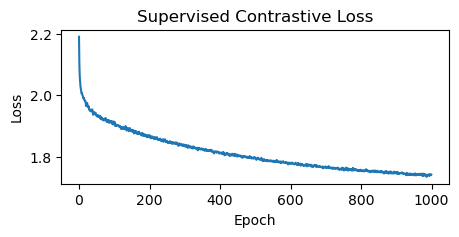

In [11]:
plt.figure(figsize=(5,2))
plt.plot(np.log(np.array(losses)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Supervised Contrastive Loss')
plt.show()

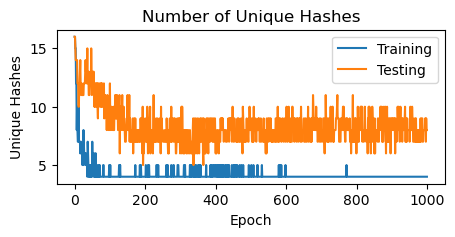

In [12]:
plt.figure(figsize=(5,2))
plt.plot(unique_training_hashes,label='Training')
plt.plot(unique_testing_hashes,label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Unique Hashes')
plt.title('Number of Unique Hashes')
plt.legend()
plt.show()

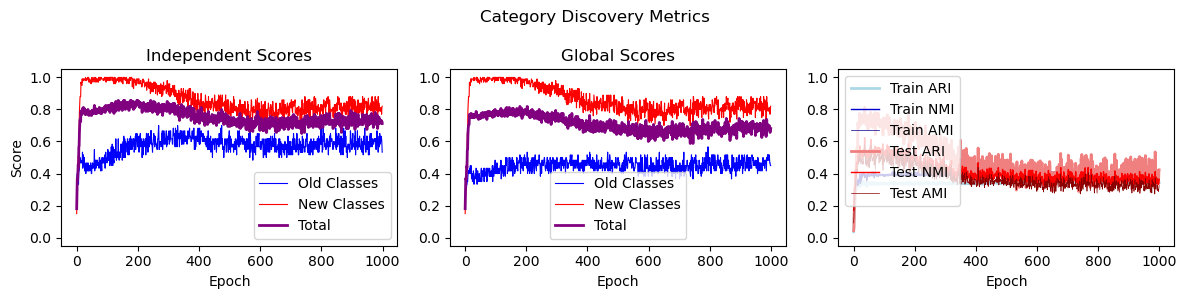

In [13]:
figs, axes = plt.subplots(1,3,figsize=(12,3))

minimum = -0.05
maximum = 1.05

# Plot independent & weighted scores
axes[0].plot(old_scores,linewidth=0.8,color='blue',label='Old Classes')
axes[0].plot(new_scores,linewidth=0.8,color='red',label='New Classes')
axes[0].plot(weighted_scores,linewidth=2,color='purple',label='Total')
axes[0].set_title('Independent Scores')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Score')
axes[0].set_ylim([minimum, maximum])
axes[0].legend()

# Plot global scores
axes[1].plot(old_global_scores,linewidth=0.8,color='blue',label='Old Classes')
axes[1].plot(new_global_scores,linewidth=0.8,color='red',label='New Classes')
axes[1].plot(global_scores,linewidth=2,color='purple',label='Total')
axes[1].set_title('Global Scores')
axes[1].set_xlabel('Epoch')
axes[1].set_ylim([minimum, maximum])
axes[1].legend()

# Plot training and testing aris
axes[2].plot(train_aris,linewidth=2,color='lightblue',label='Train ARI')
axes[2].plot(train_nmis,linewidth=1,color='mediumblue',label='Train NMI')
axes[2].plot(train_amis,linewidth=0.5,color='darkblue',label='Train AMI')
axes[2].plot(test_aris,linewidth=2,color='lightcoral',label='Test ARI')
axes[2].plot(test_nmis,linewidth=1,color='red',label='Test NMI')
axes[2].plot(test_amis,linewidth=0.5,color='darkred',label='Test AMI')
axes[2].set_title('')
axes[2].set_xlabel('Epoch')
axes[2].set_ylim([minimum, maximum])
axes[2].legend()


plt.suptitle('Category Discovery Metrics')
plt.tight_layout()
plt.show()

In [14]:
# Calculate basic statistics (means, variances, etc.) - to construct a feature vector for comparison
# Basic Statistics:
    # derivatives (do weighted averaging before taking derivatives, try out a couple different time-scales)
    # average distance between zero crossings
    # amplitude variance
    # average change in amplitude
    # angular momentums
    # periodicity
    # average distance traveled over time (is the system straying from zero over time?)
    # 

# Keep the number features on the same magnitude for both feature extraction methods
# I can calculate a lot of basic statistcs, but maybe filter down which ones I use based on importance
    # Consider using shap to filter down which features to use from the basic statistics

# Try introducing noise to see how koopman feature extractor compares with other methods - statistical methods will suffer big time with noise
# Comparing with random features for comparison to random

# Play around with the size of the encoder (more parameters than features?)
# Try making num_parameters < num_data inputs (maybe ~20%) - make only 2 layers with smaller hidden dimensions

# Change size of hash vector

# How to augment the dataset for optimized category discovery - add more categories
# Can training on more classes help discover more categories?
# Test out changing training and testing class sizes
# Compare train on 1-3 and discover 3-1

# test out different signal to noise ratios as a study


# Observations

# With a smaller neural network, it just bunches a lot of the samples into the same categories, particulary the non-harmonic ones
# The network has higher accuracy at the very beginning - this could be due to the repetitive nature of the histograms from KCM
# There are some histogram values that are repeated across different systems

In [15]:
def plot_histograms(df,combine=True,y_to_color=None,all_y_vals=None):

    all_clusters = sorted(df['cluster_id'].unique())
    unique_y = sorted(df['y'].unique()) if all_y_vals is None else sorted(all_y_vals)
    
    x = np.arange(len(all_clusters))
    width = 0.8 / len(unique_y)

    if y_to_color is None:
        cmap = plt.get_cmap('tab10')
        y_to_color = {y: cmap(i % 10) for i, y in enumerate(unique_y)}
        

    if combine:
        plt.figure(figsize=(8,3))
        for i, y_val in enumerate(unique_y):
            counts = df.loc[df['y'].eq(y_val),'cluster_id'].value_counts().reindex(all_clusters, fill_value=0)
            pmf = counts / counts.sum()
            bar_positions = x + i * width
            plt.bar(bar_positions, pmf, width=width, label=f'y = {y_val}', color=y_to_color.get(y_val, 'gray'))
        
        plt.xlabel('cluster_id')
        plt.ylabel('Frequency')
        plt.title('Cluster ID Value Counts by y')
        plt.xticks(x + width * (len(unique_y) - 1) / 2, labels=all_clusters)
        plt.legend(title='y value')
        plt.show()

    
    else:
        fig, axs = plt.subplots(len(unique_y), 1, figsize=(6, 10), constrained_layout=True)
        for i, y_val in enumerate(unique_y):
            counts = train.loc[train['y'].eq(y_val),'cluster_id'].value_counts().reindex(all_clusters, fill_value=0)
            pmf = counts / counts.sum()
            axs[i].bar(all_clusters, pmf, color=y_to_color.get(y_val, 'gray'))
            axs[i].set_title(f'Histogram of cluster_ids for y = {y_val}')
            axs[i].set_xlabel('cluster_id')
            axs[i].set_ylabel('Frequency')
            axs[i].set_xticks(all_clusters)
        plt.show()

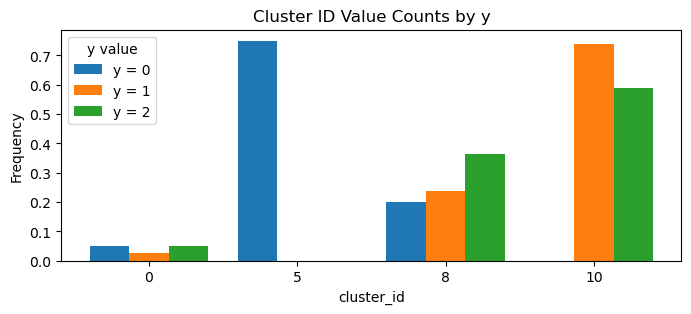

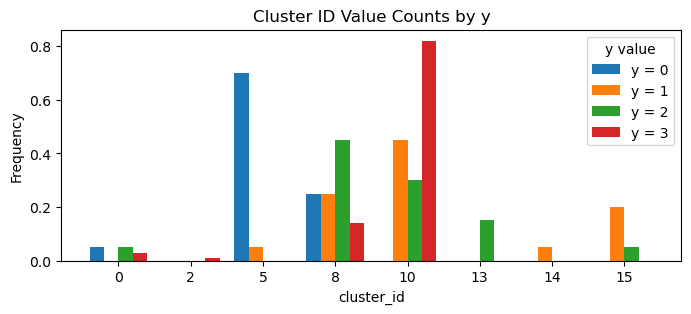

In [16]:
# data = {'cluster_id' : training_cluster_ids, 'y' : y_train}
data = {'cluster_id' : training_hash_ids, 'y' : y_train}
train = pd.DataFrame(data)

# data = {'cluster_id' : testing_cluster_ids, 'y' : y_test}
data = {'cluster_id' : testing_hash_ids, 'y' : y_test}
test = pd.DataFrame(data)

for i in range(output_dim):
    train[f'hash_{i}'] = training_hashes[:,i]
    test[f'hash_{i}'] = testing_hashes[:,i]

all_y_vals = sorted(set(train['y']).union(set(test['y'])))

# Create consistent color mapping
cmap = plt.get_cmap('tab10')
y_to_color = {y: cmap(i % 10) for i, y in enumerate(all_y_vals)}


plot_histograms(train,combine=True,y_to_color=y_to_color)
plot_histograms(test,combine=True,y_to_color=y_to_color)

In [ ]:
# [0,1,0,1,0,1,0,1]
# [1,1,1,1,0,0,0,0]